In [85]:
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from scipy import interp
%matplotlib inline

In [2]:
installments_payments_reader = pd.read_csv('datasets/unarch/installments_payments.csv', chunksize=1000)

In [3]:
installments_chunk0_df = installments_payments_reader.get_chunk()

In [4]:
installments_chunk0_df.info()
installments_chunk0_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
SK_ID_PREV                1000 non-null int64
SK_ID_CURR                1000 non-null int64
NUM_INSTALMENT_VERSION    1000 non-null float64
NUM_INSTALMENT_NUMBER     1000 non-null int64
DAYS_INSTALMENT           1000 non-null float64
DAYS_ENTRY_PAYMENT        1000 non-null float64
AMT_INSTALMENT            1000 non-null float64
AMT_PAYMENT               1000 non-null float64
dtypes: float64(5), int64(3)
memory usage: 62.6 KB


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03
mean,1.911363e+06,149831.329000,0.874000,18.448000,-1035.935000,-1045.129000,1.952597e+04,1.971942e+04
std,5.487830e+05,29345.899784,0.913761,26.438311,802.307743,801.544137,8.478509e+04,8.570838e+04
min,1.000912e+06,100012.000000,0.000000,1.000000,-2897.000000,-2897.000000,2.250000e-01,4.500000e-02
25%,1.430958e+06,123540.500000,0.000000,4.000000,-1626.250000,-1641.250000,4.493734e+03,3.503948e+03
50%,1.898868e+06,149753.500000,1.000000,8.000000,-829.500000,-835.000000,9.126630e+03,8.774843e+03
75%,2.415940e+06,175233.000000,1.000000,20.000000,-355.000000,-364.000000,1.782314e+04,1.715414e+04
max,2.843476e+06,199875.000000,13.000000,180.000000,-6.000000,-6.000000,2.292737e+06,2.292737e+06


In [5]:
installments_chunk0_df.head(4)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130


In [6]:
application_reader = pd.read_csv('datasets/unarch/application_train.csv', chunksize=1000)

In [7]:
application_chunk0_df = application_reader.get_chunk()

In [8]:
application_chunk0_df.info()
application_chunk0_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 953.2+ KB


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,9.990000e+02,1000.000000,1000.00000,1000.000000,...,1000.000000,1000.0,1000.0,1000.0,856.000000,856.000000,856.000000,856.000000,856.000000,856.000000
mean,100575.487000,0.070000,0.406000,167660.480655,5.953064e+05,27120.672000,5.361982e+05,0.021132,-15872.74800,55733.906000,...,0.005000,0.0,0.0,0.0,0.009346,0.007009,0.036215,0.231308,0.290888,1.900701
std,331.664661,0.255275,0.713914,90167.625149,3.884752e+05,14278.923334,3.596362e+05,0.014033,4235.85437,134159.108526,...,0.070569,0.0,0.0,0.0,0.096277,0.118262,0.204846,0.750984,0.649398,1.903693
min,100002.000000,0.000000,0.000000,31500.000000,4.797000e+04,4504.500000,4.500000e+04,0.001333,-25104.00000,-15632.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,100289.750000,0.000000,0.000000,112500.000000,2.735842e+05,16603.875000,2.385000e+05,0.010006,-19229.00000,-2724.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,100576.500000,0.000000,0.000000,144000.000000,5.165145e+05,25371.000000,4.500000e+05,0.018850,-15743.00000,-1267.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,100862.250000,0.000000,1.000000,202500.000000,8.086500e+05,34103.250000,6.795000e+05,0.028663,-12326.50000,-304.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,101156.000000,1.000000,3.000000,765000.000000,2.286212e+06,116266.500000,2.250000e+06,0.072508,-7705.00000,365243.000000,...,1.000000,0.0,0.0,0.0,1.000000,3.000000,3.000000,9.000000,4.000000,9.000000


In [9]:
application_chunk0_df.head(4)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
bureau_balance_reader = pd.read_csv('datasets/unarch/bureau_balance.csv', chunksize=1000)

In [11]:
bureau_balance_chunk0_df = bureau_balance_reader.get_chunk()

In [12]:
bureau_balance_chunk0_df.info()
bureau_balance_chunk0_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
SK_ID_BUREAU      1000 non-null int64
MONTHS_BALANCE    1000 non-null int64
STATUS            1000 non-null object
dtypes: int64(2), object(1)
memory usage: 23.5+ KB


,SK_ID_BUREAU,MONTHS_BALANCE
count,1.000000e+03,1000.000000
mean,5.716339e+06,-26.454000
std,9.096482e+02,21.366385
min,5.715448e+06,-91.000000
25%,5.715458e+06,-40.000000
50%,5.715795e+06,-21.000000
75%,5.717364e+06,-9.000000
max,5.717371e+06,0.000000


In [13]:
bureau_balance_chunk0_df.head(4)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C


In [14]:
bureau_reader = pd.read_csv('datasets/unarch/bureau.csv', chunksize=1000)

In [15]:
bureau_chunk0_df = bureau_reader.get_chunk()

In [16]:
bureau_chunk0_df.info()
bureau_chunk0_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
SK_ID_CURR                1000 non-null int64
SK_ID_BUREAU              1000 non-null int64
CREDIT_ACTIVE             1000 non-null object
CREDIT_CURRENCY           1000 non-null object
DAYS_CREDIT               1000 non-null int64
CREDIT_DAY_OVERDUE        1000 non-null int64
DAYS_CREDIT_ENDDATE       934 non-null float64
DAYS_ENDDATE_FACT         644 non-null float64
AMT_CREDIT_MAX_OVERDUE    407 non-null float64
CNT_CREDIT_PROLONG        1000 non-null int64
AMT_CREDIT_SUM            1000 non-null float64
AMT_CREDIT_SUM_DEBT       850 non-null float64
AMT_CREDIT_SUM_LIMIT      701 non-null float64
AMT_CREDIT_SUM_OVERDUE    1000 non-null float64
CREDIT_TYPE               1000 non-null object
DAYS_CREDIT_UPDATE        1000 non-null int64
AMT_ANNUITY               69 non-null float64
dtypes: float64(8), int64(6), object(3)
memory usage: 132.9+ KB


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1000.000000,1.000000e+03,1000.000000,1000.000000,934.000000,644.000000,407.000000,1000.00000,1.000000e+03,8.500000e+02,701.000000,1000.000000,1000.000000,69.000000
mean,295502.330000,5.715104e+06,-1158.419000,2.639000,334.905782,-1023.223602,2985.488182,0.00800,3.280675e+05,1.116980e+05,8723.971027,0.578025,-615.630000,10146.841304
std,98130.825874,3.670286e+02,804.710472,82.318631,4612.938747,722.467557,12001.409743,0.11811,7.467505e+05,4.375428e+05,40760.279667,11.822679,663.447031,15449.843501
min,101060.000000,5.714462e+06,-2918.000000,0.000000,-2723.000000,-2723.000000,0.000000,0.00000,0.000000e+00,-2.692170e+03,0.000000,0.000000,-2723.000000,0.000000
25%,221642.000000,5.714786e+06,-1667.000000,0.000000,-1216.500000,-1499.250000,0.000000,0.00000,4.764294e+04,0.000000e+00,0.000000,0.000000,-868.250000,0.000000
50%,296586.000000,5.715114e+06,-1042.000000,0.000000,-424.500000,-880.000000,0.000000,0.00000,1.085468e+05,0.000000e+00,0.000000,0.000000,-477.500000,5895.000000
75%,387080.000000,5.715424e+06,-496.750000,0.000000,408.500000,-436.500000,0.000000,0.00000,2.488639e+05,1.105200e+04,0.000000,0.000000,-35.750000,13131.000000
max,456062.000000,5.715716e+06,-5.000000,2603.000000,31132.000000,-4.000000,140631.840000,2.00000,7.794000e+06,5.685700e+06,495000.000000,288.000000,0.000000,67995.000000


In [17]:
bureau_chunk0_df.head(4)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN


In [18]:
credit_card_balance_reader = pd.read_csv('datasets/unarch/credit_card_balance.csv', chunksize=1000)

In [19]:
credit_card_balance_chunk0_df = credit_card_balance_reader.get_chunk()

In [20]:
credit_card_balance_chunk0_df.info()
credit_card_balance_chunk0_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 23 columns):
SK_ID_PREV                    1000 non-null int64
SK_ID_CURR                    1000 non-null int64
MONTHS_BALANCE                1000 non-null int64
AMT_BALANCE                   1000 non-null float64
AMT_CREDIT_LIMIT_ACTUAL       1000 non-null int64
AMT_DRAWINGS_ATM_CURRENT      863 non-null float64
AMT_DRAWINGS_CURRENT          1000 non-null float64
AMT_DRAWINGS_OTHER_CURRENT    863 non-null float64
AMT_DRAWINGS_POS_CURRENT      863 non-null float64
AMT_INST_MIN_REGULARITY       1000 non-null float64
AMT_PAYMENT_CURRENT           861 non-null float64
AMT_PAYMENT_TOTAL_CURRENT     1000 non-null float64
AMT_RECEIVABLE_PRINCIPAL      1000 non-null float64
AMT_RECIVABLE                 1000 non-null float64
AMT_TOTAL_RECEIVABLE          1000 non-null float64
CNT_DRAWINGS_ATM_CURRENT      863 non-null float64
CNT_DRAWINGS_CURRENT          1000 non-null int64
CNT_DRAWINGS_OTHER_CURREN

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,863.000000,1000.000000,863.00000,863.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,863.000000,1000.000000,863.000000,863.000000,1000.000000,1000.000000,1000.000000
mean,1.935696e+06,281529.045000,-4.225000,135151.663050,255946.500000,6700.463499,16891.463565,419.86095,12403.871176,6812.555850,...,130224.952125,134427.780585,134427.780585,0.339513,2.474000,0.003476,2.523754,20.456000,4.701000,0.021000
std,5.357626e+05,101663.837312,2.034334,175448.477264,218302.288758,25004.691899,50793.963573,7813.55114,46675.072585,8770.021989,...,169511.002502,174692.993015,174692.993015,1.050645,7.207307,0.058891,7.606419,21.444625,90.089576,0.383022
min,1.000355e+06,100218.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.463149e+06,201105.750000,-6.000000,0.000000,67500.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
50%,1.955958e+06,285787.500000,-4.000000,57185.797500,225000.000000,0.000000,0.000000,0.00000,0.000000,2317.027500,...,55836.472500,56980.845000,56980.845000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
75%,2.378655e+06,370590.500000,-3.000000,226431.753750,450000.000000,0.000000,11891.621250,0.00000,6583.725000,11513.238750,...,218617.706250,224841.093750,224841.093750,0.000000,2.000000,0.000000,1.500000,29.000000,0.000000,0.000000
max,2.841868e+06,455348.000000,-1.000000,940575.195000,900000.000000,337500.000000,849442.320000,177840.00000,849442.320000,46728.540000,...,898514.910000,933656.625000,933656.625000,13.000000,101.000000,1.000000,101.000000,111.000000,2192.000000,7.000000


In [21]:
pos_cash_balance_reader = pd.read_csv('datasets/unarch/POS_CASH_balance.csv', chunksize=1000)

In [22]:
pos_cash_balance_chunk0_df = pos_cash_balance_reader.get_chunk()

In [23]:
pos_cash_balance_chunk0_df.info()
pos_cash_balance_chunk0_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
SK_ID_PREV               1000 non-null int64
SK_ID_CURR               1000 non-null int64
MONTHS_BALANCE           1000 non-null int64
CNT_INSTALMENT           998 non-null float64
CNT_INSTALMENT_FUTURE    998 non-null float64
NAME_CONTRACT_STATUS     1000 non-null object
SK_DPD                   1000 non-null int64
SK_DPD_DEF               1000 non-null int64
dtypes: float64(2), int64(5), object(1)
memory usage: 62.6+ KB


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000000e+03,1000.00000,1000.000000,998.000000,998.000000,1000.000000,1000.000000
mean,1.895437e+06,278600.19500,-31.682000,19.922846,10.247495,0.082000,0.071000
std,5.345190e+05,100710.12171,10.692296,8.916252,8.512182,0.850882,0.815245
min,1.000882e+06,100187.00000,-48.000000,1.000000,0.000000,0.000000,0.000000
25%,1.425364e+06,193089.50000,-39.000000,12.000000,5.000000,0.000000,0.000000
50%,1.881834e+06,278555.00000,-34.000000,24.000000,8.000000,0.000000,0.000000
75%,2.343862e+06,368365.50000,-26.000000,24.000000,12.000000,0.000000,0.000000
max,2.837716e+06,456070.00000,-1.000000,60.000000,56.000000,18.000000,18.000000


In [24]:
previous_application_reader = pd.read_csv('datasets/unarch/previous_application.csv', chunksize=1000)

In [25]:
previous_application_chunk0_df = previous_application_reader.get_chunk()

In [26]:
previous_application_chunk0_df.info()
previous_application_chunk0_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 37 columns):
SK_ID_PREV                     1000 non-null int64
SK_ID_CURR                     1000 non-null int64
NAME_CONTRACT_TYPE             1000 non-null object
AMT_ANNUITY                    802 non-null float64
AMT_APPLICATION                1000 non-null float64
AMT_CREDIT                     1000 non-null float64
AMT_DOWN_PAYMENT               562 non-null float64
AMT_GOODS_PRICE                807 non-null float64
WEEKDAY_APPR_PROCESS_START     1000 non-null object
HOUR_APPR_PROCESS_START        1000 non-null int64
FLAG_LAST_APPL_PER_CONTRACT    1000 non-null object
NFLAG_LAST_APPL_IN_DAY         1000 non-null int64
RATE_DOWN_PAYMENT              562 non-null float64
RATE_INTEREST_PRIMARY          6 non-null float64
RATE_INTEREST_PRIVILEGED       6 non-null float64
NAME_CASH_LOAN_PURPOSE         1000 non-null object
NAME_CONTRACT_STATUS           1000 non-null object
DAYS_DECISION   

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.000000e+03,1000.000000,802.000000,1.000000e+03,1.000000e+03,562.000000,8.070000e+02,1000.000000,1000.000000,562.000000,...,6.000000,1000.000000,1.000000e+03,802.000000,630.000000,630.000000,630.000000,630.000000,630.000000,630.000000
mean,1.928381e+06,273594.013000,14483.800661,1.502111e+05,1.690141e+05,5954.177642,1.861351e+05,12.646000,0.997000,0.077342,...,0.803118,-913.147000,4.304662e+03,14.278055,348401.500000,13434.547619,24833.461905,72817.384127,75149.976190,0.269841
std,5.358070e+05,100768.807734,13140.094322,2.453016e+05,2.739886e+05,11435.177289,2.605503e+05,3.297811,0.054717,0.105328,...,0.115763,816.454382,1.264837e+05,12.630492,76729.945912,71576.670707,93356.532272,147056.180687,148755.300279,0.444230
min,1.000588e+06,100077.000000,1097.640000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,3.000000,0.000000,0.000000,...,0.568710,-2920.000000,-1.000000e+00,0.000000,-2709.000000,-2886.000000,-2780.000000,-2780.000000,-2724.000000,0.000000
25%,1.481392e+06,186544.750000,6213.633750,2.680650e+04,2.961338e+04,0.000000,4.855500e+04,10.000000,1.000000,0.000000,...,0.835095,-1330.250000,-1.000000e+00,6.000000,365243.000000,-1569.000000,-1286.500000,-1300.500000,-1274.250000,0.000000
50%,1.911370e+06,270712.500000,10014.570000,6.997500e+04,7.423650e+04,4.207500,9.414450e+04,12.000000,1.000000,0.000105,...,0.840116,-591.000000,2.500000e+01,12.000000,365243.000000,-817.000000,-426.000000,-561.500000,-551.000000,0.000000
75%,2.397933e+06,354867.750000,17914.455000,1.569262e+05,1.732208e+05,7648.875000,1.856902e+05,15.000000,1.000000,0.108916,...,0.861786,-285.500000,1.205000e+02,18.000000,365243.000000,-377.250000,60.500000,-89.250000,-57.250000,1.000000
max,2.836013e+06,455912.000000,83041.200000,2.025000e+06,2.241513e+06,112500.000000,2.025000e+06,22.000000,1.000000,0.695678,...,0.867336,-4.000000,4.000000e+06,60.000000,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [27]:
sample_submission_reader = pd.read_csv('datasets/unarch/sample_submission.csv', chunksize=1000)

In [28]:
sample_submission_chunk0_df = sample_submission_reader.get_chunk()

In [29]:
sample_submission_chunk0_df.info()
sample_submission_chunk0_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
SK_ID_CURR    1000 non-null int64
TARGET        1000 non-null float64
dtypes: float64(1), int64(1)
memory usage: 15.7 KB


,SK_ID_CURR,TARGET
count,1000.000000,1000.0
mean,103466.418000,0.5
std,1984.302605,0.0
min,100001.000000,0.5
25%,101681.000000,0.5
50%,103479.000000,0.5
75%,105196.250000,0.5
max,106861.000000,0.5


In [30]:
num_of_application_chunks = 0
for chunk in application_reader.get_chunk():
    num_of_application_chunks += 1
print(num_of_application_chunks)

122


In [31]:
def count_chunks(reader):
    chunks_counter = 0
    for chunk in reader:
        chunks_counter += 1
    return chunks_counter

In [32]:
def get_random_seq_from_range(range_size, seq_size, seed_value=0):
    random.seed(seed_value)
    return sorted(random.sample(range(range_size), seq_size))

In [33]:
def get_dataset_random_parts(dataset_file_path, parts_ratio, seed_value=0, chunksize=1000):
    dataset_reader = pd.read_csv(dataset_file_path, chunksize=chunksize)
    chunks_quantity = count_chunks(dataset_reader)
    dataset_reader.close()
    selected_chunks_indexes = get_random_seq_from_range(
        chunks_quantity,
        int(chunks_quantity * parts_ratio),
        seed_value
    )
    print(chunks_quantity)
    print(selected_chunks_indexes)
    print(len(selected_chunks_indexes))
    dataset_reader = pd.read_csv(dataset_file_path, chunksize=chunksize)
    parts_list = []
    chunks_counter = 0
    for chunk in dataset_reader:
        if chunks_counter in selected_chunks_indexes:
            print(type(chunk))
            parts_list.append(chunk)
        chunks_counter += 1
    dataset_reader.close()
    return parts_list  

In [34]:
def catenate_dataset_parts(dataset_parts):
    return pd.concat(dataset_parts, ignore_index=True)

In [35]:
def reduce_df_types(df):
    for column in df.columns:
        if df[column].dtype == np.float64:
            #df[column].astype(np.float32, copy=False)
            df.loc[:, column] = df[column].astype(np.float32)
        elif df[column].dtype == np.int64:
            #df[column].astype(np.int32, copy=False)
            df.loc[:, column] = df[column].astype(np.int32)
    return df

In [36]:
random.seed(0)
application_random_part = catenate_dataset_parts(get_dataset_random_parts('datasets/unarch/application_train.csv', 0.1))

308
[20, 37, 48, 50, 51, 71, 75, 104, 111, 128, 132, 144, 155, 158, 161, 169, 181, 183, 197, 207, 215, 222, 241, 244, 248, 258, 261, 272, 286, 298]
30
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'panda

In [37]:
application_random_part.info()
application_random_part.describe()
application_random_part

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 27.9+ MB


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123326,0,Cash loans,F,N,Y,0,49500.0,619965.0,18256.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,2.0
1,123327,0,Cash loans,M,Y,Y,0,112500.0,562981.5,33655.5,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
2,123329,0,Cash loans,F,N,N,0,112500.0,1291500.0,37759.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,123332,0,Cash loans,M,Y,N,1,225000.0,1006920.0,51543.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,123333,0,Cash loans,F,N,Y,0,157500.0,507469.5,29263.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
5,123335,0,Cash loans,F,N,Y,0,360000.0,902209.5,49072.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
6,123336,0,Cash loans,M,Y,N,0,179100.0,942300.0,30528.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
7,123337,0,Cash loans,F,N,N,0,135000.0,675000.0,34641.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,123338,0,Cash loans,F,N,Y,1,90000.0,414792.0,25195.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
9,123339,0,Cash loans,F,N,Y,1,112500.0,528633.0,22527.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [38]:
#application_random_part = reduce_df_types(application_random_part)

In [39]:
nan_columns_total = 0
for column_name in application_random_part.columns.tolist():
    column = application_random_part[column_name]
    is_null_boolean = column.isnull()
    if any(is_null_boolean):
        print(column_name, ":")
        print("NaN quantity: ", is_null_boolean.sum())
        print("colum type: ", column.dtype)
        nan_columns_total += 1

print("NaN columns total: ", nan_columns_total)        

AMT_ANNUITY :
NaN quantity:  5
colum type:  float64
AMT_GOODS_PRICE :
NaN quantity:  22
colum type:  float64
NAME_TYPE_SUITE :
NaN quantity:  115
colum type:  object
OWN_CAR_AGE :
NaN quantity:  19757
colum type:  float64
OCCUPATION_TYPE :
NaN quantity:  9542
colum type:  object
EXT_SOURCE_1 :
NaN quantity:  16837
colum type:  float64
EXT_SOURCE_2 :
NaN quantity:  68
colum type:  float64
EXT_SOURCE_3 :
NaN quantity:  6066
colum type:  float64
APARTMENTS_AVG :
NaN quantity:  15224
colum type:  float64
BASEMENTAREA_AVG :
NaN quantity:  17580
colum type:  float64
YEARS_BEGINEXPLUATATION_AVG :
NaN quantity:  14616
colum type:  float64
YEARS_BUILD_AVG :
NaN quantity:  19918
colum type:  float64
COMMONAREA_AVG :
NaN quantity:  20932
colum type:  float64
ELEVATORS_AVG :
NaN quantity:  15954
colum type:  float64
ENTRANCES_AVG :
NaN quantity:  15057
colum type:  float64
FLOORSMAX_AVG :
NaN quantity:  14893
colum type:  float64
FLOORSMIN_AVG :
NaN quantity:  20321
colum type:  float64
LANDAREA_A

In [40]:
#column0 = application_random_part['SK_ID_CURR']

In [41]:
#olumn0 == 1

In [42]:
'''
i = 0
for chunk in application_reader:
    print(chunk.tail(4))
    if i == 3:
        break
    i += 1
'''

'\ni = 0\nfor chunk in application_reader:\n    print(chunk.tail(4))\n    if i == 3:\n        break\n    i += 1\n'

In [43]:
#application_random_part.fillna?
imp = Imputer(strategy='most_frequent')

In [44]:
#application_random_part_imp_most_freq = imp.fit(application_random_part)

In [45]:
column2 = application_random_part['NAME_CONTRACT_TYPE']

In [46]:
column2.mode()
column2.hasnans

False

In [47]:
for column_name in application_random_part.columns.tolist():
    if application_random_part[column_name].hasnans:
        print(application_random_part[column_name].mode())
        print(type(application_random_part[column_name].mode()))
        application_random_part[column_name].fillna(application_random_part[column_name].mode()[0], inplace=True)

0    9000.0
dtype: float64
<class 'pandas.core.series.Series'>
0    225000.0
dtype: float64
<class 'pandas.core.series.Series'>
0    Unaccompanied
dtype: object
<class 'pandas.core.series.Series'>
0    7.0
dtype: float64
<class 'pandas.core.series.Series'>
0    Laborers
dtype: object
<class 'pandas.core.series.Series'>
0    0.475689
1    0.617008
dtype: float64
<class 'pandas.core.series.Series'>
0    0.285898
dtype: float64
<class 'pandas.core.series.Series'>
0    0.713631
dtype: float64
<class 'pandas.core.series.Series'>
0    0.0825
dtype: float64
<class 'pandas.core.series.Series'>
0    0.0
dtype: float64
<class 'pandas.core.series.Series'>
0    0.9871
dtype: float64
<class 'pandas.core.series.Series'>
0    0.8232
dtype: float64
<class 'pandas.core.series.Series'>
0    0.0
dtype: float64
<class 'pandas.core.series.Series'>
0    0.0
dtype: float64
<class 'pandas.core.series.Series'>
0    0.1379
dtype: float64
<class 'pandas.core.series.Series'>
0    0.1667
dtype: float64
<class 'pan

In [48]:
for column_name in application_random_part.columns.tolist():
    if application_random_part[column_name].hasnans:
        print(column_name)

In [49]:
application_random_part['NONLIVINGAPARTMENTS_MODE']

0        0.0000
1        0.0000
2        0.0000
3        0.0000
4        0.0000
5        0.0000
6        0.0000
7        0.0000
8        0.0000
9        0.0000
10       0.0000
11       0.0000
12       0.0000
13       0.0000
14       0.0000
15       0.0000
16       0.0000
17       0.0000
18       0.0000
19       0.0000
20       0.0000
21       0.0000
22       0.0000
23       0.0000
24       0.0000
25       0.0078
26       0.0000
27       0.0000
28       0.0000
29       0.0117
          ...  
29970    0.0000
29971    0.0000
29972    0.0000
29973    0.0000
29974    0.0078
29975    0.0039
29976    0.0000
29977    0.0000
29978    0.0078
29979    0.0000
29980    0.0000
29981    0.0000
29982    0.0117
29983    0.0000
29984    0.0000
29985    0.0000
29986    0.0078
29987    0.0000
29988    0.0000
29989    0.0000
29990    0.0000
29991    0.0117
29992    0.0000
29993    0.0000
29994    0.0039
29995    0.0000
29996    0.0000
29997    0.0039
29998    0.0000
29999    0.0000
Name: NONLIVINGAPARTMENT

In [50]:
application_random_part = reduce_df_types(application_random_part)

In [51]:
name_contract_type = application_random_part['NAME_CONTRACT_TYPE']

In [52]:
name_contract_type.dtypes

dtype('O')

In [53]:
print(application_random_part.dtypes)

SK_ID_CURR                      int32
TARGET                          int32
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int32
AMT_INCOME_TOTAL              float32
AMT_CREDIT                    float32
AMT_ANNUITY                   float32
AMT_GOODS_PRICE               float32
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float32
DAYS_BIRTH                      int32
DAYS_EMPLOYED                   int32
DAYS_REGISTRATION             float32
DAYS_ID_PUBLISH                 int32
OWN_CAR_AGE                   float32
FLAG_MOBIL                      int32
FLAG_EMP_PHONE                  int32
FLAG_WORK_PHONE                 int32
FLAG_CONT_MOBILE                int32
FLAG_PHONE  

In [54]:
#name_contract_type.astype?

In [55]:
application_random_part.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float32(65), int32(41), object(16)
memory usage: 15.8+ MB


In [56]:
object_columns = []
for column_name in application_random_part.columns.tolist():
    if application_random_part[column_name].dtype == np.object:
        print(column_name)
        print(pd.unique(application_random_part[column_name]))
        object_columns.append(column_name)

NAME_CONTRACT_TYPE
['Cash loans' 'Revolving loans']
CODE_GENDER
['F' 'M']
FLAG_OWN_CAR
['N' 'Y']
FLAG_OWN_REALTY
['Y' 'N']
NAME_TYPE_SUITE
['Unaccompanied' 'Family' 'Children' 'Spouse, partner' 'Other_B' 'Other_A'
 'Group of people']
NAME_INCOME_TYPE
['Pensioner' 'Working' 'Commercial associate' 'State servant' 'Unemployed'
 'Student' 'Maternity leave']
NAME_EDUCATION_TYPE
['Secondary / secondary special' 'Incomplete higher' 'Higher education'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS
['Married' 'Civil marriage' 'Single / not married' 'Widow' 'Separated']
NAME_HOUSING_TYPE
['Municipal apartment' 'House / apartment' 'Rented apartment'
 'Office apartment' 'With parents' 'Co-op apartment']
OCCUPATION_TYPE
['Laborers' 'Drivers' 'Sales staff' 'Cleaning staff' 'Medicine staff'
 'High skill tech staff' 'Core staff' 'Managers' 'Cooking staff'
 'Accountants' 'Secretaries' 'HR staff' 'Security staff' 'Realty agents'
 'Waiters/barmen staff' 'Low-skill Laborers' 'IT staff'
 'Private

In [57]:
hot_encoded = pd.get_dummies(application_random_part)

In [58]:
hot_encoded.head(3)

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,123326,0,0,49500.0,619965.0,18256.5,517500.0,0.031329,-21194,365243,...,0,0,0,0,0,1,0,0,1,0
1,123327,0,0,112500.0,562981.5,33655.5,486000.0,0.010556,-10244,-1916,...,0,0,0,0,0,0,1,0,1,0
2,123329,0,0,112500.0,1291500.0,37759.5,1291500.0,0.006233,-10367,-425,...,0,0,0,0,0,1,0,0,1,0


In [59]:
for column_name in hot_encoded.columns.tolist():
    if hot_encoded[column_name].dtype == np.object:
        print(column_name)
        print(pd.unique(hot_encoded[column_name]))

In [60]:
hot_encoded_columns = [
    hot_encoded_column_name for
    hot_encoded_column_name in
    hot_encoded.columns.tolist()
    if hot_encoded_column_name not in application_random_part.columns.tolist()
]

In [61]:
print(hot_encoded_columns)
print(len(hot_encoded_columns))

['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_F', 'CODE_GENDER_M', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student', 'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Civil marriage', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Wid

In [62]:
application_random_part_categorical_int = application_random_part.copy()

In [63]:
for column_name in application_random_part_categorical_int.columns.tolist():
    if application_random_part_categorical_int[column_name].dtype == np.object:
        application_random_part_categorical_int[column_name] = pd.Categorical(application_random_part_categorical_int[column_name]).codes.astype(np.int32)       

In [64]:
application_random_part_categorical_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float32(65), int32(57)
memory usage: 14.0 MB


In [65]:
y = application_random_part_categorical_int.pop('TARGET')

In [66]:
X = application_random_part_categorical_int

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [68]:
y_train.head()

21177    0
23942    0
1247     0
23622    0
28454    1
Name: TARGET, dtype: int32

In [69]:
cv_params = {'max_depth': [3, 5, 7], 'min_child_weight': [1, 3, 5]}
ind_params = {
    'learning_rate': 0.1,
    'n_estimators': 100,
    'seed': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'objective': 'binary:logistic'
}

In [70]:
optimized_GBM = GridSearchCV(
    xgb.XGBClassifier(**ind_params),
    cv_params,
    scoring='accuracy',
    cv=5,
    n_jobs = -1
)
#%time optimized_GBM.fit(X_train, y_train)

In [71]:
#kle.dump(optimized_GBM, open('optimized_GBM.pkl', 'wb'))

In [74]:
optimized_GBM = pickle.load(open('optimized_GBM.pkl', 'rb'))

In [75]:
sns.set(font_scale=1.5)

In [76]:
type(optimized_GBM.best_estimator_)

xgboost.sklearn.XGBClassifier

In [77]:
best_optimized_GBM = optimized_GBM.best_estimator_

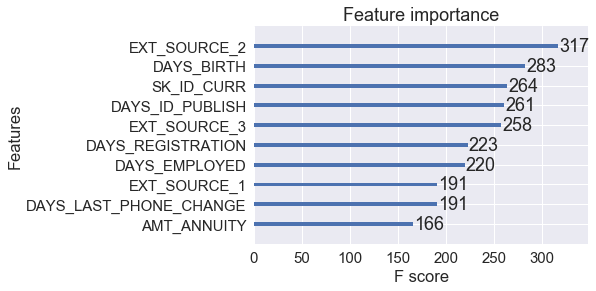

In [78]:
xgb.plot_importance(best_optimized_GBM, max_num_features=10)

In [79]:
testdmat = xgb.DMatrix(X_test)

In [80]:
y_pred = best_optimized_GBM.predict(X_test)

In [81]:
y_pred[y_pred != 0][:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [82]:
accuracy_score(y_pred, y_test)

0.91839999999999999

In [86]:
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)

In [87]:
confmat

array([[6876,   15],
       [ 597,   12]])

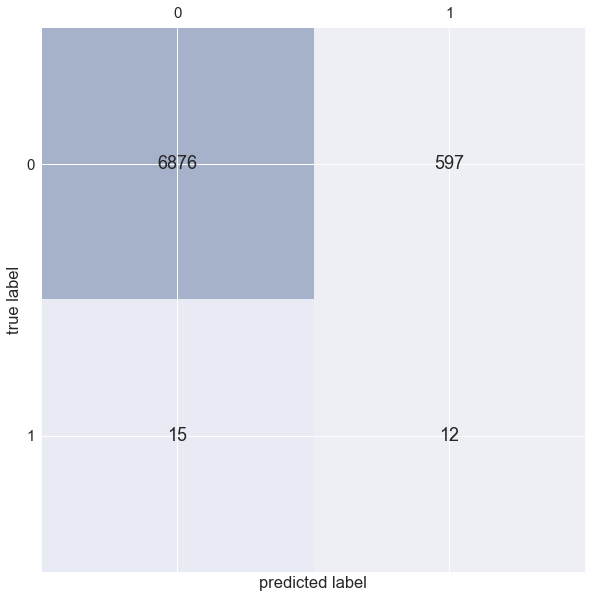

In [96]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=i, y=j, s=confmat[i, j], va='center', ha='center', fontsize=18)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()